# **Machine Learning for Neuroimaging 2023 — Assignment 3**

**Course:** PSYC221 - Machine Learning for Neuroimaging, Assignment 3

**Name:** Alice Heiman

**Date:** XX November, 2023

*The following notebook is adapted and built upon the "Starter Code" provided in the Assignment 3 description.*

## **ABIDE I Functional Connectome Analysis**

You have been provided with a resting-state fMRI connectome dataset of 120 individuals diagnosed with Autism Spectrum Disorder (ASD) and 120 typical controls. Each connectome, i.e., each subject’s brain network and properties, is encoded as an 𝑁-by-𝑁 correlation matrix 𝐌, where $M_{i,j}$ is the functional connectivity (correlation in activation patterns) between region $i$ and region $j$.

Note that this is the preprocessed version of ABIDE provided by the Preprocessed Connectome Project (PCP).

For more information about this dataset's structure: http://preprocessed-connectomes-project.org/abide/

*Cameron Craddock, Yassine Benhajali, Carlton Chu, Francois Chouinard, Alan Evans, András Jakab, Budhachandra Singh Khundrakpam, John David Lewis, Qingyang Li, Michael Milham, Chaogan Yan, Pierre Bellec (2013). The Neuro Bureau Preprocessing Initiative: open sharing of preprocessed neuroimaging data and derivatives. In Neuroinformatics 2013, Stockholm, Sweden.*

**Relevant Libraries**
*  [NumPy](https://numpy.org/): For numerical computing and handling multi-dimensional data.
*  [Pandas](https://pandas.pydata.org/): For structured data operations and manipulations.
*  [Matplotlib](https://matplotlib.org/): For creating static, interactive, and animated visualizations in Python.
*  [scikit-learn](https://scikit-learn.org/stable/): For implementing machine learning algorithms.
*  [nibabel](https://nipy.org/nibabel/): For reading and writing neuroimaging data formats.
*  [nilearn](https://nilearn.github.io/stable/index.html): For advanced neuroimaging data manipulation and visualization.
*  [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/): For writing and training Graph Neural Networks (GNNs).
*  [DGL (Deep Graph Library)](https://www.dgl.ai/): For deep learning on GNNs.

In [2]:
%%capture
# @title Run to install needed packages.
!pip install nilearn torch torchvision torchaudio torch-geometric

In [3]:
# @title Load parcellated, connectivity matrices as our features, X
import numpy as np
import pickle as pkl
from nilearn.connectome import ConnectivityMeasure

'''
Load the connectivity matrices
Note: each connectivity matrix (sample) was derived using the NiftiLabelsMasker
and ConnectivityMeasure [with full Pearson's correlation] from nilearn and each
sample was also standardized by z-score
[i.e., zero mean scaled to unit variance w.r.t. sample std]
'''

data_path = './ABIDE_240.npz'
# Load the data
data = np.load(data_path)

# Accessing the arrays
connectomes = data['features']
y_abide = data['labels']

print("Data loaded from NPZ file.")

# Check the number of subject functional scans fetched
print(f"Number of subjects: {len(connectomes)}")

FileNotFoundError: [Errno 2] No such file or directory: './ABIDE_240.npz'

In [1]:
connectomes

NameError: name 'connectomes' is not defined

In [13]:
from nilearn import plotting
from nilearn import datasets

# Retrieve AAL brain atlas for parcellation, more info here: https://www.sciencedirect.com/science/article/pii/S1053811901909784
parcellations = datasets.fetch_atlas_aal()
atlas_filename = parcellations.maps
labels = parcellations.labels
print(f"Number of ROIs: {len(labels)}")

Number of ROIs: 116


## Q1.

**Challenge:** Use an approach of your choice (machine learning or statistical group analysis) to identify noticeable differences in correlation values between control subjects and those diagnosed with ASD. Based on your findings, what are the implications of these findings in understanding ASD impact on brain function? Feel free to use supporting literature to cite your claims. 

Plot a random connectivity matrix from the dataset.

---

Connectivity matrix shape: (116, 116)


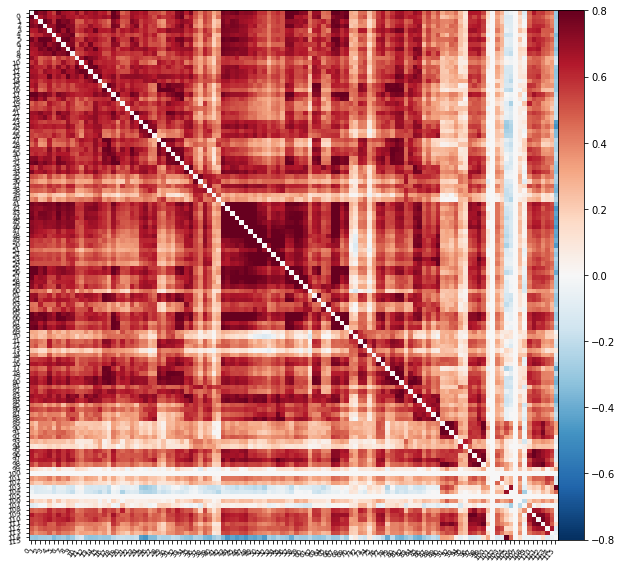

In [4]:
cm_sample = connectomes[47]
print(f"Connectivity matrix shape: {cm_sample.shape}")

np.fill_diagonal(cm_sample, 0)

plotting.plot_matrix(cm_sample, figure=(10, 8),
                     labels=range(cm_sample.shape[-1]),
                     vmax=0.8, vmin=-0.8, reorder=False)

The labels contain diagnostic group each participant is in. It is coded as:

*   1 = Autism Spectrum Disorder (ASD)
*   2 = Control

Let's re-index this to 0=ASD and 1=Control due to zero-indexed systems required for ML and other data processing software.

In [5]:
from collections import Counter

# Adjust labels to start from 0
y_abide = y_abide - 1

# Print label classes and counts
print(Counter(y_abide))

Counter({0: 120, 1: 120})


Now, you're ready to prepare the data for machine learning or statistical analysis.

Note: If you are interested in using graph neural networks, feel free to use the below PyG starter code to create your custom PyG Dataset. Check the assignment description for links to related tutorials.

---

In [ ]:
# @title [GraphML ONLY] Create custom PyG ConnectomeDataset
import torch
from torch_geometric.data import Data, Dataset
from torch_geometric.utils import dense_to_sparse

class ConnectomeDataset(Dataset):
    def __init__(self, connectivity_matrices, labels, task="classification", transform=None, pre_transform=None):
        super(ConnectomeDataset, self).__init__(None, transform, pre_transform)
        self.connectivity_matrices = connectivity_matrices
        self.labels = labels
        self.task = task

    def len(self):
        return len(self.connectivity_matrices)

    def get(self, idx):
        # Convert the connectivity matrix to edge index and edge attributes
        connectivity_matrix = torch.tensor(self.connectivity_matrices[idx])
        edge_index, edge_attr = dense_to_sparse(connectivity_matrix)

        # Create a data object
        data = Data(edge_index=edge_index, edge_attr=edge_attr)
        data.x = connectivity_matrix.to(torch.float)
        if self.task == "classification":
            data.y = torch.tensor([self.labels[idx]-1], dtype=torch.long) # make labels start at 0
        else:
            data.y = torch.tensor([self.labels[idx]], dtype=torch.float)
        return data

### Example - GraphML Classification

In [ ]:
import torch
import torch_geometric.transforms as T
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader

# Instantiate the dataset
abide_dataset = ConnectomeDataset(connectomes, y_abide)

loader = DataLoader(abide_dataset, batch_size=32, shuffle=True)

print(f'Number of graphs: {len(abide_dataset)}')
print("Number of node features: ", abide_dataset.num_node_features)
print(f'Number of edge features: {abide_dataset.num_edge_features}')

num_classes = 2

# TO DO: Define a Graph Neural Network model
#...

## Q2.

### Example - Graph Network Metrics

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 'cm_sample' is a random connectome from our dataset
weights = cm_sample[np.triu_indices_from(cm_sample, k=1)]  # Extract upper triangle to avoid duplication

# Plotting the distribution of weights
plt.hist(weights, bins=30, alpha=0.7)
plt.title("Distribution of Edge Weights")
plt.xlabel("Weight (Correlation Value)")
plt.ylabel("Frequency")
plt.show()


### Example - Network Community Detection

In [ ]:
import networkx as nx
import numpy as np
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt

from matplotlib import colormaps

'''Note: networkx expects non-negative edge weights for community detection;
convert connectome edge weights to absolute value (changes edge weight
information to strength only and not whether positively or negatively
correlated.)
'''
# Find the absolute maximum value in the connectome for scaling
abs_cm_sample = np.abs(cm_sample)

G = nx.from_numpy_array(abs_cm_sample)

# Use the Louvain method for community detection
partition = community_louvain.best_partition(G, weight='weight')

# Visualize the communities
pos = nx.spring_layout(G)  # Positioning of the nodes
cmap = colormaps['viridis']

for com in set(partition.values()):
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size=20,
                           node_color=[cmap(com / (max(partition.values()) + 1))])

nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()
